In [ ]:
!pip install sodapy

In [1]:
import pandas as pd
import numpy as np
import altair as alt
from sodapy import Socrata
import datetime as dt

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('fivethirtyeight')
sns.set_style('whitegrid')
from plotly.offline import init_notebook_mode, iplot
import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.tools as tls
import warnings
warnings.filterwarnings('ignore')
import re
import time
import networkx as nx
import plotly.express as px
from plotly.subplots import make_subplots

In [3]:
alt.data_transformers.disable_max_rows()

DataTransformerRegistry.enable('default')

In [4]:
client = Socrata("data.cityofnewyork.us", "1E6CgkxfC6xJuYVZjQakYsJLb")
results = client.get("h9gi-nx95", limit=1000000)

In [5]:
data_df = pd.DataFrame.from_records(results)
data_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000000 entries, 0 to 999999
Data columns (total 29 columns):
 #   Column                         Non-Null Count    Dtype 
---  ------                         --------------    ----- 
 0   crash_date                     1000000 non-null  object
 1   crash_time                     1000000 non-null  object
 2   on_street_name                 755772 non-null   object
 3   number_of_persons_injured      999983 non-null   object
 4   number_of_persons_killed       999970 non-null   object
 5   number_of_pedestrians_injured  1000000 non-null  object
 6   number_of_pedestrians_killed   1000000 non-null  object
 7   number_of_cyclist_injured      1000000 non-null  object
 8   number_of_cyclist_killed       1000000 non-null  object
 9   number_of_motorist_injured     1000000 non-null  object
 10  number_of_motorist_killed      1000000 non-null  object
 11  contributing_factor_vehicle_1  996434 non-null   object
 12  contributing_factor_vehicle_2

In [6]:
data_df['crash_date'].max()

'2022-06-05T00:00:00.000'

In [7]:
data_df['crash_date'].min()

'2012-07-27T00:00:00.000'

In [8]:
data_df.isnull().sum()

crash_date                            0
crash_time                            0
on_street_name                   244228
number_of_persons_injured            17
number_of_persons_killed             30
number_of_pedestrians_injured         0
number_of_pedestrians_killed          0
number_of_cyclist_injured             0
number_of_cyclist_killed              0
number_of_motorist_injured            0
number_of_motorist_killed             0
contributing_factor_vehicle_1      3566
contributing_factor_vehicle_2    169681
collision_id                          0
vehicle_type_code1                 8063
vehicle_type_code2               236035
borough                          359465
zip_code                         359637
latitude                          71200
longitude                         71200
location                          71200
cross_street_name                757055
off_street_name                  517313
contributing_factor_vehicle_3    926438
contributing_factor_vehicle_4    982947


In [10]:
data_df = data_df[data_df['crash_date']>='2016-01-01T00:00:00.000']
data_df = data_df[data_df['crash_date']<'2021-12-31T00:00:00.000']
data_df = data_df.reset_index(drop=True)

In [11]:
data_df['crash_date'].max()

'2021-12-30T00:00:00.000'

In [12]:
data_df['crash_date'].min()

'2016-03-15T00:00:00.000'

In [13]:
text_columns = ['on_street_name', 'off_street_name', 'contributing_factor_vehicle_1', 'contributing_factor_vehicle_2','contributing_factor_vehicle_3', 'contributing_factor_vehicle_4','contributing_factor_vehicle_5', 'vehicle_type_code1', 'vehicle_type_code2', 'vehicle_type_code_3', 'vehicle_type_code_4', 'vehicle_type_code_5' ]
for column in text_columns:
    data_df[column] = data_df[column].str.upper() 

In [14]:
data_df[text_columns] = data_df[text_columns].fillna('MISSING')

In [15]:
df = data_df

In [17]:
data_df["crash_dt"] = pd.to_datetime(data_df['crash_date'])
data_df["year"] = data_df.crash_dt.dt.year
data_df["month"] = data_df.crash_dt.dt.month
data_df["weeknumber"] = data_df.crash_dt.dt.weekofyear
data_df["day"] = data_df.crash_dt.dt.day
data_df["dayofyear"] = data_df.crash_dt.dt.dayofyear
data_df["weekday"] = data_df.crash_dt.dt.weekday
data_df['hour'] = pd.to_datetime(data_df['crash_time'], format='%H:%M').dt.hour
# source=source.loc[data_df["zip"]]
data_df['zip_code'] = data_df['zip_code'].apply(str)
data_df['zip_code'] = data_df['zip_code'].str.split('.',expand=True)[0]

for index, row in data_df.iterrows():
    # print("hello")
    if row["hour"]>=8 and  row["hour"]<10:
      data_df.at[index, "peak"]="Morning Peak"
    elif row["hour"]>=16 and  row["hour"]<18:
      data_df.at[index, "peak"]="Evening Peak"
    else:
      data_df.at[index, "peak"]="Not Peak"
# print(data_df.head())
source = data_df.groupby(['weekday', 'peak']).size().to_frame('counts').reset_index()

max = source['counts'].max()
min = source['counts'].min()

alt.Chart(source).mark_rect().encode(
    alt.X('peak:O', axis=alt.Axis(labelAngle=-0)),
    alt.Y('weekday:O'),
    alt.Color('counts', bin=alt.Bin(extent=[min, max], step=2000), 
        scale=alt.Scale(scheme='greenblue'),
        legend=alt.Legend(title='Total Records')
    )
).properties(
    width=600,
    title='Weekday By Hour '
)


alt.Chart(...)

In [19]:
#  3   number_of_persons_injured      number_of_persons_injured
#  4   number_of_persons_killed       number_of_persons_injured
#  5   number_of_pedestrians_injured  1672500 non-null  object
#  6   number_of_pedestrians_killed   1672500 non-null  object
#  7   number_of_cyclist_injured      1672500 non-null  object
#  8   number_of_cyclist_killed       1672500 non-null  object
#  9   number_of_motorist_injured     1672500 non-null  object
#  10  number_of_motorist_killed      1672500 non-null  object
data_df['number_of_persons_injured'] = data_df['number_of_persons_injured'].apply(float)
data_df['number_of_persons_killed'] = data_df['number_of_persons_killed'].apply(float)
data_df['number_of_pedestrians_injured'] = data_df['number_of_pedestrians_injured'].apply(float)
data_df['number_of_pedestrians_killed'] = data_df['number_of_pedestrians_killed'].apply(float)
data_df['number_of_cyclist_injured'] = data_df['number_of_cyclist_injured'].apply(float)
data_df['number_of_cyclist_killed'] = data_df['number_of_cyclist_killed'].apply(float)
data_df['number_of_motorist_injured'] = data_df['number_of_motorist_injured'].apply(float)
data_df['number_of_motorist_killed'] = data_df['number_of_motorist_killed'].apply(float)



### Analysis along zip codes

In [21]:
source = data_df.groupby(['borough', 'zip_code']).size().reset_index(name='counts')
source=source.set_index("borough")

bronx=source.loc["BRONX"]
bronx=bronx.reset_index()
bronx=bronx.loc[bronx["counts"]!=0]
bronx=bronx.loc[bronx["counts"]>=bronx["counts"].mean()]

brooklyn=source.loc["BROOKLYN"]
brooklyn=brooklyn.reset_index()
brooklyn=brooklyn.loc[brooklyn["counts"]!=0]
brooklyn=brooklyn.loc[brooklyn["counts"]>=brooklyn["counts"].mean()]

manhattan=source.loc["MANHATTAN"]
manhattan=manhattan.reset_index()
manhattan=manhattan.loc[manhattan["counts"]!=0]
manhattan=manhattan.loc[manhattan["counts"]>=manhattan["counts"].mean()]

queens=source.loc["QUEENS"]
queens=queens.reset_index()
queens=queens.loc[queens["counts"]!=0]
queens=queens.loc[queens["counts"]>=queens["counts"].mean()]

staten_island=source.loc["STATEN ISLAND"]
staten_island=staten_island.reset_index()
staten_island=staten_island.loc[staten_island["counts"]!=0]
# staten_island=staten_island.loc[staten_island["counts"]>=staten_island["counts"].mean()]

chart1 = alt.Chart(bronx).mark_bar().encode(
    alt.X('counts:Q'),
    alt.Y('zip_code:O',sort='-x'),
    
).properties(
    height=300,
    width=200,
     title='Bronx-Collision over Zipcode'
)


chart2 = alt.Chart(brooklyn).mark_bar().encode(
    alt.X('counts:Q'),
    alt.Y('zip_code:O',sort='-x'),
    
).properties(
    height=300,
    width=200,
    title='Brooklyn-Collision over Zipcode'
)

chart3 = alt.Chart(manhattan).mark_bar().encode(
    alt.X('counts:Q'),
    alt.Y('zip_code:O',sort='-x'),
    
).properties(
    height=300,
    width=200,
    title='Manhattan-Collision over Zipcode'
)


chart4 = alt.Chart(queens).mark_bar().encode(
    alt.X('counts:Q'),
    alt.Y('zip_code:O',sort='-x'),
    
).properties(
  height=300,
    width=200,
    title='Queens-Collision over Zipcode'
)

chart5 = alt.Chart(staten_island).mark_bar().encode(
    alt.X('counts:Q'),
    alt.Y('zip_code:O',sort='-x'),
    
).properties(
    height=300,
    width=200,
    title='Staten Island-Collision over Zipcode'
)

chart1 | chart2 | chart3 | chart4 | chart5
# bronx.head()
# chart1

alt.HConcatChart(...)

In [22]:
source = data_df.groupby(['borough', 'zip_code']).size().reset_index(name='counts')
source['percentage'] = source.counts / source.counts.sum()
source = source.sort_values('percentage', ascending=False).groupby('borough').head(5)

bars = alt.Chart().mark_bar().encode(
    x=alt.X('zip_code:N', sort='-y', axis=alt.Axis(labelAngle=-90)),
    y=alt.Y('percentage:Q', axis=alt.Axis(format='%', labelAngle=-0), title="Percentage of Total Collisions"),
    color='borough',
    text='counts:Q'
)

alt.layer(bars, data=source).properties(
    height=300,
    width=600,
    title='Top 5 most dangerous zipcodes of each borough, sorted'
)

alt.LayerChart(...)

In [23]:
source = data_df.groupby(['borough', 'zip_code', 'peak']).size().reset_index(name='counts')
source=source.loc[source["borough"]=="BROOKLYN"]
source=source.loc[source["peak"]=="Morning Peak"]
source
source = source.sort_values('counts', ascending=False).groupby([ 'peak']).head()
base = alt.Chart(source).mark_bar().encode(
    x=alt.X('zip_code:O', title='Zip Code',axis=alt.Axis(labelAngle=-0),sort="-y"),
    y=alt.Y('counts:Q', title="Total Collisions"),
    # color='peak:N',
).properties(
    height=400,
    width=400,
    title='Most dangerous zipcode in each borough over the years'
).facet(
    column="peak"
)

source = data_df.groupby(['borough', 'zip_code', 'peak']).size().reset_index(name='counts')
source=source.loc[source["borough"]=="BROOKLYN"]
source=source.loc[source["peak"]=="Evening Peak"]
source
source = source.sort_values('counts', ascending=False).groupby([ 'peak']).head()
base1 = alt.Chart(source).mark_bar().encode(
    x=alt.X('zip_code:O', title='Zip Code',axis=alt.Axis(labelAngle=-0),sort="-y"),
    y=alt.Y('counts:Q', title="Total Collisions"),
    # color='peak:N',
).properties(
    height=400,
    width=400,
    title='Most dangerous zipcode in each borough over the years'
).facet(
    column="peak"
)
base | base1

alt.HConcatChart(...)

In [24]:

source = data_df.groupby(['borough', 'zip_code', 'year']).size().reset_index(name='counts')
source = source.sort_values('counts', ascending=False).groupby(['borough', 'year']).head(1)
base = alt.Chart(source).mark_area().encode(
    x=alt.X('year:O', title='Year', axis=alt.Axis(labelAngle=-0)),
    y=alt.Y('counts:Q', title="Total Collisions"),
    color='zip_code:N',
).properties(
    height=200,
    width=300,
)

texts = base.mark_text(
    align='center',
    baseline='bottom',
).encode(
    text='zip_code:Q'
)

alt.layer(base, texts, data=source).facet(
    column='borough',
    title='Most dangerous zipcode in each borough over the years'
)

alt.FacetChart(...)

### Analysis along Borough

<AxesSubplot:title={'center':'Collisions over Borough-Count'}, xlabel='borough'>

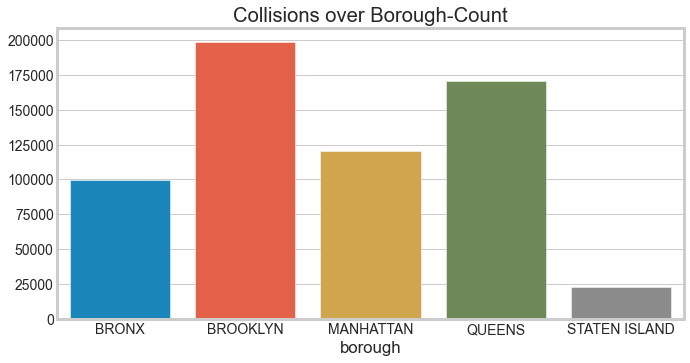

In [25]:
plt.figure(figsize=(10,5))
plt.title('Collisions over Borough-Count')
sns.barplot(x=data_df.groupby('borough').size().index,
            y=data_df.groupby('borough').size().values)

<AxesSubplot:xlabel='borough', ylabel='number_of_persons_killed'>

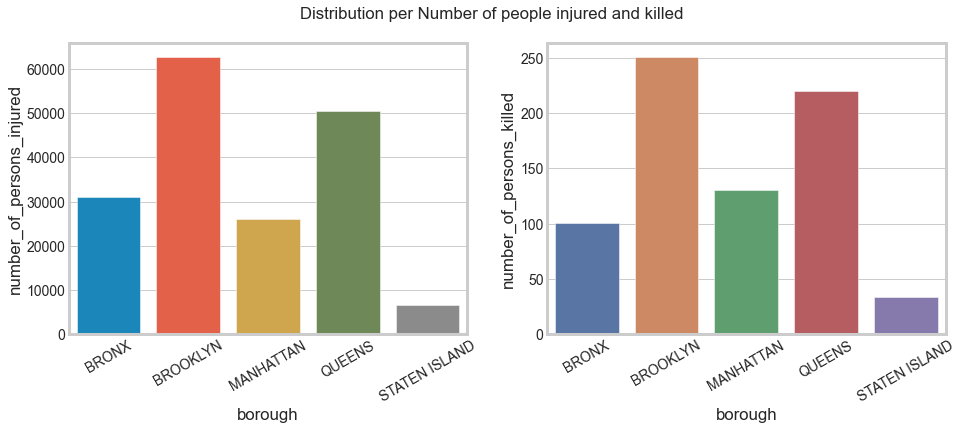

In [26]:
accidents_bor_df = data_df.groupby('borough')[['number_of_persons_injured', 'number_of_persons_killed']].sum()

fig, ax = plt.subplots(1,2,figsize=(14,5))
plt.suptitle('Distribution per Number of people injured and killed')

ax[1].set_xticklabels(labels=accidents_bor_df.index,rotation=30)
ax[0].set_xticklabels(labels=accidents_bor_df.index,rotation=30)

sns.barplot(accidents_bor_df.index, accidents_bor_df['number_of_persons_injured'], ax=ax[0])
sns.barplot(accidents_bor_df.index, accidents_bor_df['number_of_persons_killed'], ax=ax[1], palette='deep')

Text(0.5, 1.0, 'Total % of Traffic Accidents by Borough in NYC')

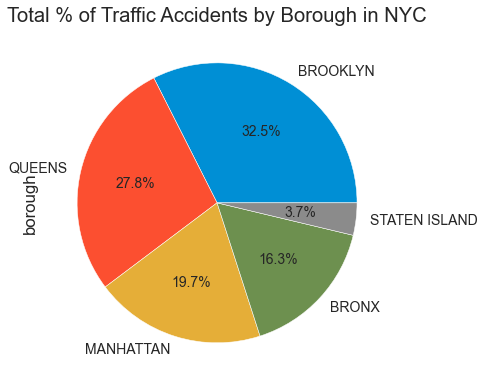

In [27]:
data_df['borough'].value_counts().plot(kind = 'pie',autopct='%1.1f%%',figsize=(6,6))
plt.title('Total % of Traffic Accidents by Borough in NYC')

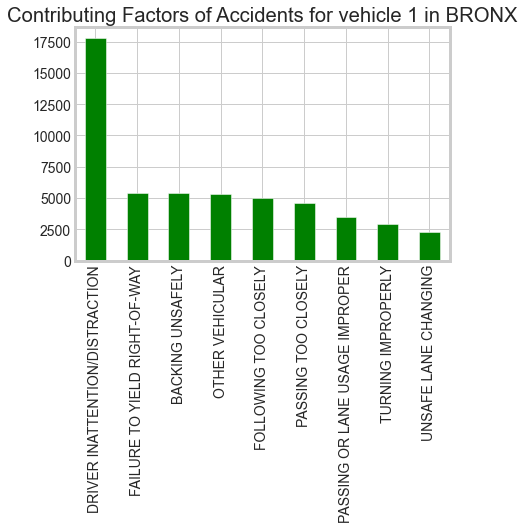

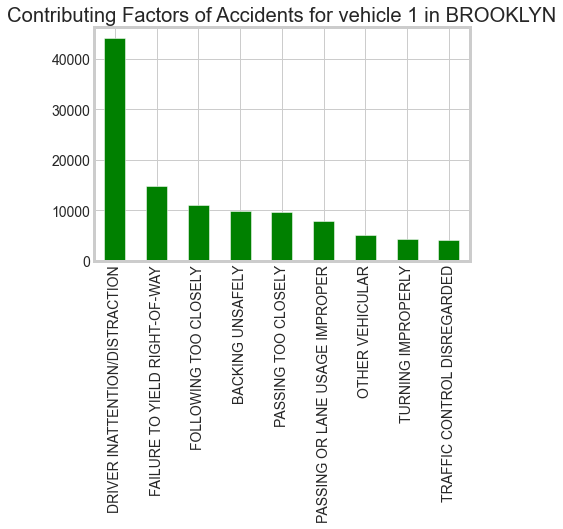

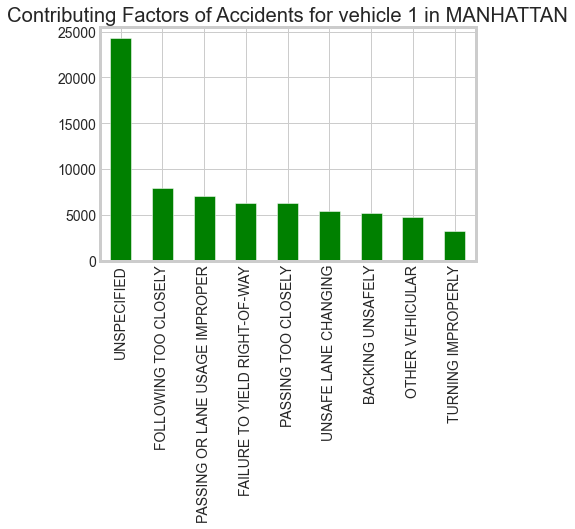

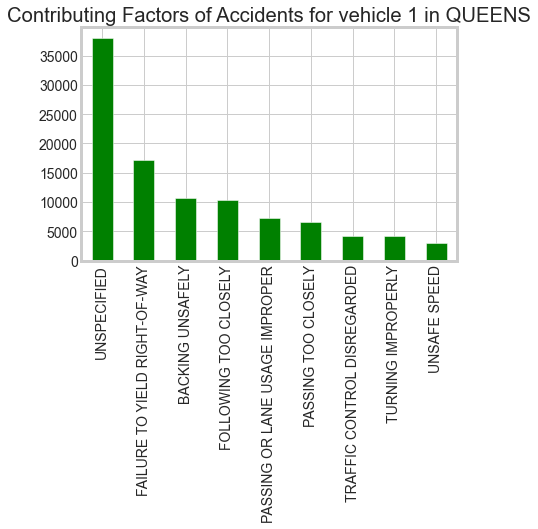

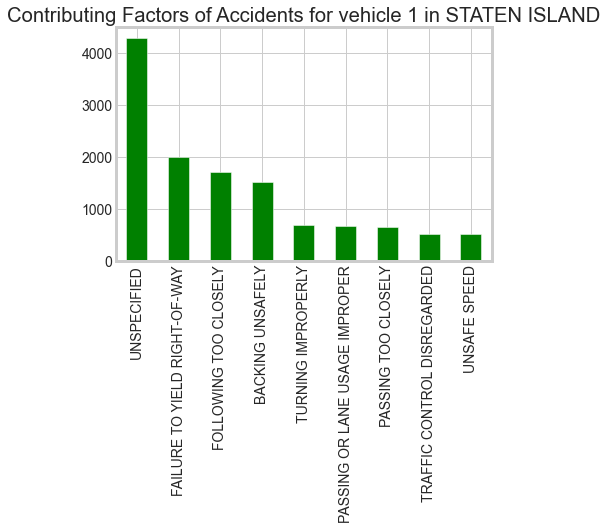

In [29]:
crimeByArea = data_df['borough'].value_counts().sort_index()
crimeCommonType = {} # This dictionary is for later
for area in crimeByArea.keys():
    crimeArea = data_df[data_df['borough'] == area]['contributing_factor_vehicle_1'].value_counts()[1:10]
    for crType in crimeArea.keys():
        if not crType in crimeCommonType:
            crimeCommonType[crType] = [area]
        else:
            crimeCommonType[crType].append(area)
    crimeArea = crimeArea.plot(kind = 'bar',title = "Contributing Factors of Accidents for vehicle 1 in " + area, color = 'green')
    plt.show()

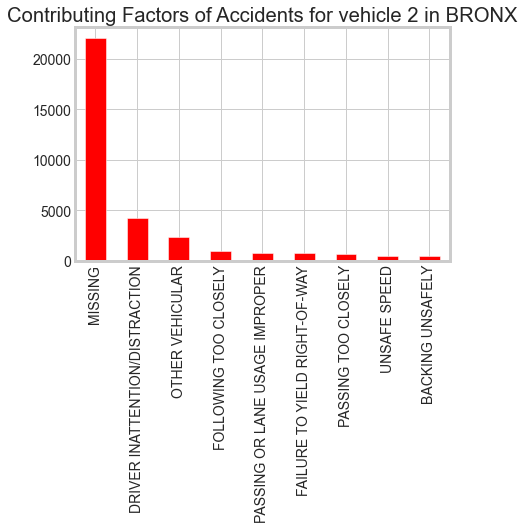

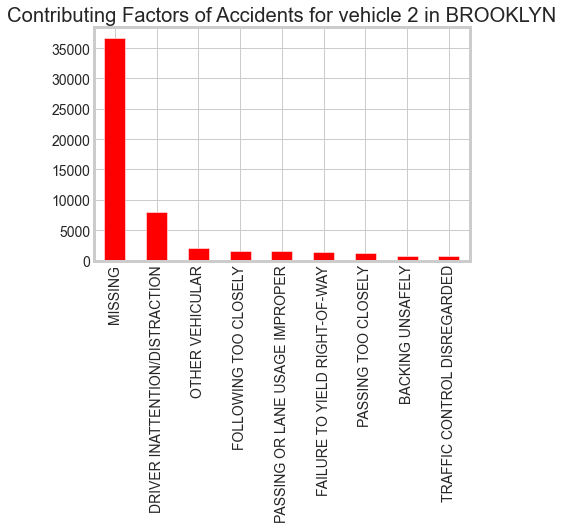

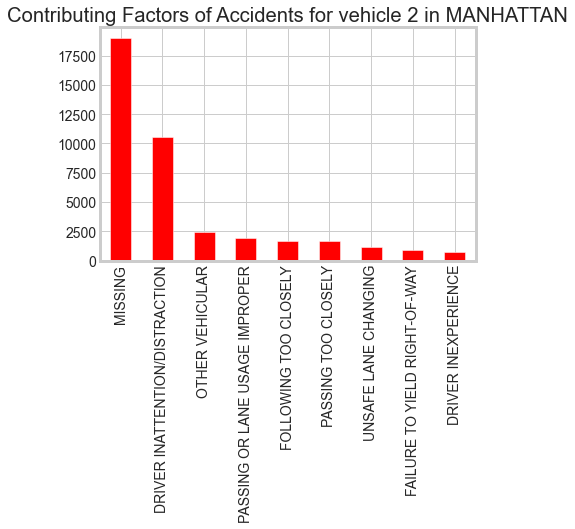

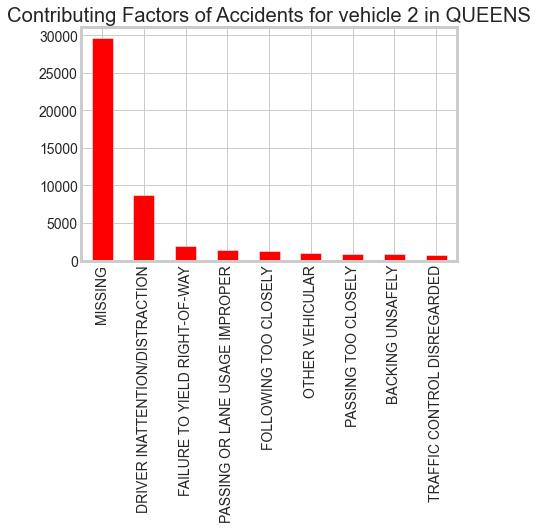

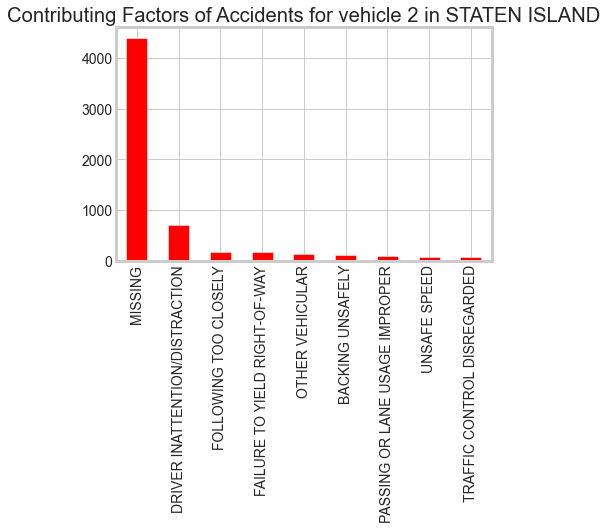

In [30]:
crimeByArea = data_df['borough'].value_counts().sort_index()
crimeCommonType = {} # This dictionary is for later
for area in crimeByArea.keys():
    crimeArea = data_df[data_df['borough'] == area]['contributing_factor_vehicle_2'].value_counts()[1:10]
    for crType in crimeArea.keys():
        if not crType in crimeCommonType:
            crimeCommonType[crType] = [area]
        else:
            crimeCommonType[crType].append(area)
    crimeArea = crimeArea.plot(kind = 'bar',title = "Contributing Factors of Accidents for vehicle 2 in " + area, color = 'red')
    plt.show()

### Analysis by time

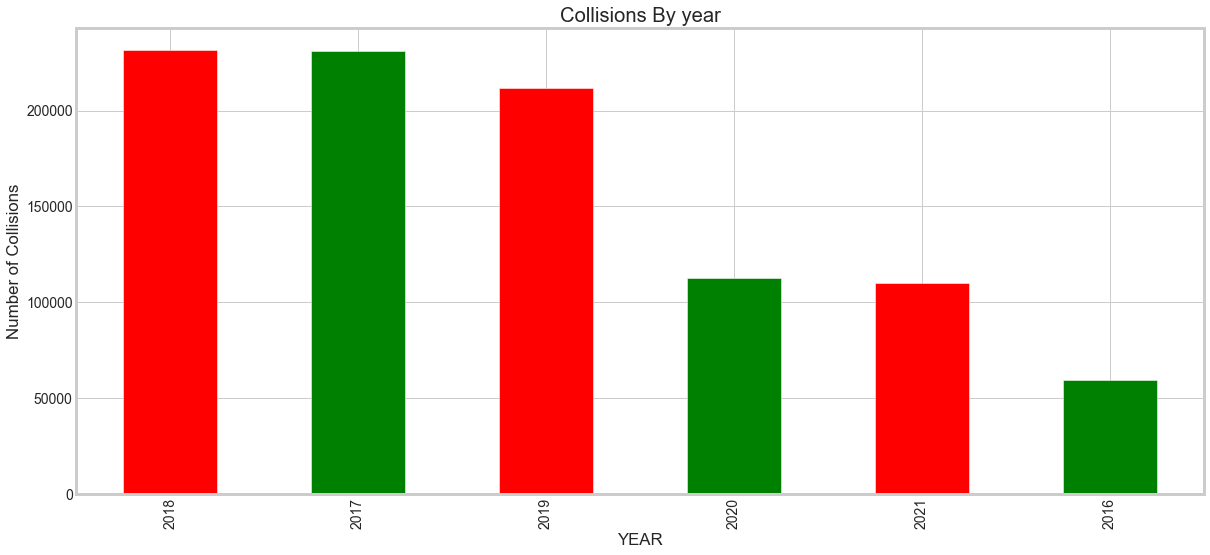

In [31]:
#plot_order = data_df.sort_val(by="year", ascending=True)
pd.value_counts(data_df["year"]).plot.bar(color=['red','green'])
plt.xlabel('YEAR')
plt.ylabel('Number of Collisions')
plt.title('Collisions By year')
plt.gcf().set_size_inches(18, 8)
plt.show()

In [32]:
data_df['number_of_pedestrians_injured'] = data_df['number_of_pedestrians_injured'].apply(int)

In [33]:
borough_injuries_month = data_df.groupby([data_df.month, data_df.borough])['number_of_pedestrians_injured'].sum().unstack()


In [34]:
borough_by_biggest_population = ['MANHATTAN', 'BROOKLYN', 'QUEENS', 'BRONX', 'STATEN ISLAND']
borough_injuries_month = borough_injuries_month[borough_by_biggest_population]


In [35]:
### Monthly statistics by the borough ###

months = ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December']
months_abbr = [m[:3] for m in months]

borough_injuries_month.index = months
borough_injuries_month

borough,MANHATTAN,BROOKLYN,QUEENS,BRONX,STATEN ISLAND
January,655,1196,902,594,91
February,618,917,764,513,69
March,612,1000,714,546,56
April,487,739,548,387,47
May,600,947,629,498,67
June,505,899,592,502,75
July,530,859,521,481,61
August,515,829,558,467,47
September,656,974,688,519,73
October,826,1340,996,662,111


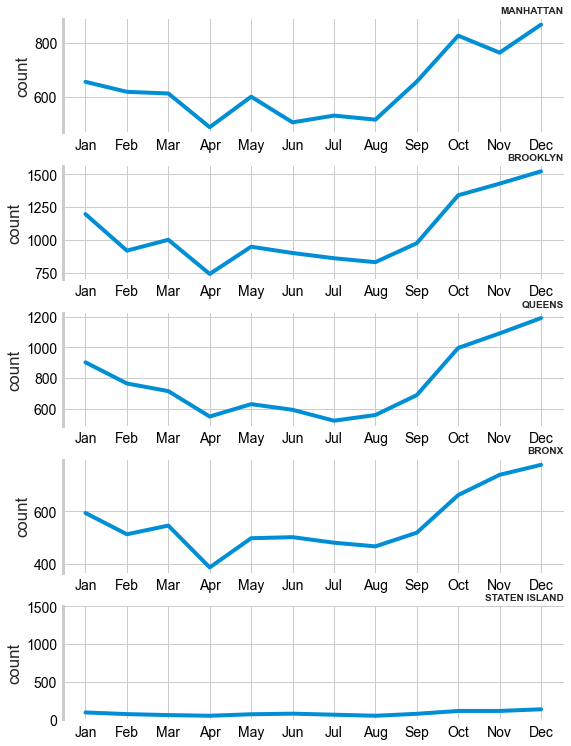

In [36]:
### Monthly trends by the borough ###

# Set up the matplotlib figure
f, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(5, 1, figsize=(8, 12), sharex=False, sharey=False)
f.subplots_adjust(hspace=.3)

for boro, ax in zip(borough_injuries_month, [ax1, ax2, ax3, ax4, ax5]):
    values = borough_injuries_month[boro].values
#     colors = ['gray' if (x < max()) else 'red' for x in values]
    sns.lineplot(months_abbr, borough_injuries_month[boro], palette='deep', ax=ax)
    ax.set_title(boro, loc='right', weight='bold', fontdict={'fontsize': 10})
    ax.set_ylabel('count')
#     ax.set_xlabel('month')
    ax.tick_params(direction='inout', length=4, width=1, colors='black')
    sns.despine(bottom=True)

plt.ylim(0, 1500)
plt.show();

In [37]:
frm = borough_injuries_month

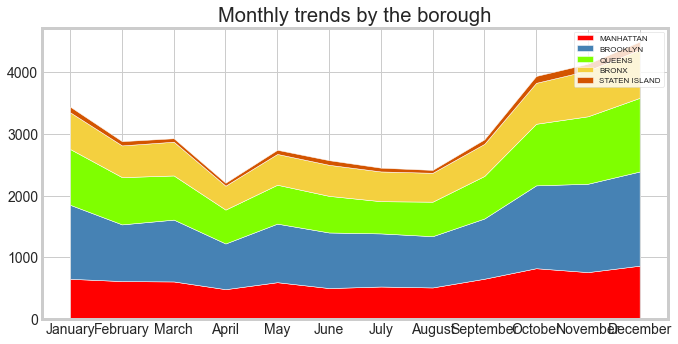

In [38]:
# sns.set_theme()
plt.figure(figsize=(10,5))
label = ['MANHATTAN', 'BROOKLYN', 'QUEENS', 'BRONX', 'STATEN ISLAND']
colormap= ['red', 'steelblue', 'chartreuse', '#F4D03F', '#D35400', '#7D3C98']
plt.stackplot(frm.index, frm['MANHATTAN'], frm['BROOKLYN'], frm['QUEENS'], frm['BRONX'], frm['STATEN ISLAND'], colors=colormap, labels=label)
plt.title("Monthly trends by the borough")
plt.legend(fontsize=8) 

In [39]:
year = data_df[['number_of_persons_injured',
       'number_of_persons_killed', 'number_of_pedestrians_injured',
       'number_of_pedestrians_killed', 'number_of_cyclist_injured',
       'number_of_cyclist_killed', 'number_of_motorist_injured',
                    'number_of_motorist_killed','year']]

In [40]:
### Casualties over the year in the collisions ###

year.groupby('year').sum()

,number_of_persons_injured,number_of_persons_killed,number_of_pedestrians_injured,number_of_pedestrians_killed,number_of_cyclist_injured,number_of_cyclist_killed,number_of_motorist_injured,number_of_motorist_killed
year,,,,,,,,
2016,15570.0,63.0,3286,47.0,1152.0,1.0,10936.0,13.0
2017,60656.0,256.0,11151,127.0,4889.0,27.0,44615.0,107.0
2018,61941.0,231.0,11123,123.0,4725.0,10.0,46070.0,98.0
2019,61389.0,244.0,10568,131.0,4986.0,31.0,45834.0,82.0
2020,44606.0,268.0,6690,101.0,5576.0,29.0,32340.0,138.0
2021,51669.0,293.0,7482,130.0,4950.0,19.0,37110.0,132.0


### Analysis by type of vehicles and people

In [41]:
data_df.rename(columns = {'vehicle_type_code1' : 'vehicle_type_code_1', 'vehicle_type_code2' : 'vehicle_type_code_2'}, inplace = True)

In [42]:
data_df.columns

Index(['crash_date', 'crash_time', 'on_street_name',
       'number_of_persons_injured', 'number_of_persons_killed',
       'number_of_pedestrians_injured', 'number_of_pedestrians_killed',
       'number_of_cyclist_injured', 'number_of_cyclist_killed',
       'number_of_motorist_injured', 'number_of_motorist_killed',
       'contributing_factor_vehicle_1', 'contributing_factor_vehicle_2',
       'collision_id', 'vehicle_type_code_1', 'vehicle_type_code_2', 'borough',
       'zip_code', 'latitude', 'longitude', 'location', 'cross_street_name',
       'off_street_name', 'contributing_factor_vehicle_3',
       'contributing_factor_vehicle_4', 'vehicle_type_code_3',
       'vehicle_type_code_4', 'contributing_factor_vehicle_5',
       'vehicle_type_code_5', 'crash_dt', 'year', 'month', 'weeknumber', 'day',
       'dayofyear', 'weekday', 'hour', 'peak'],
      dtype='object')

In [43]:
df['vehicle_type_code_5'] = data_df['vehicle_type_code_5'].str.lower()

In [44]:
for i in range(5):
    feat = 'vehicle_type_code_'+str(i+1)
    print("Number of values for ",feat, " = ",len(data_df[feat].unique()))

Number of values for  vehicle_type_code_1  =  856
Number of values for  vehicle_type_code_2  =  935
Number of values for  vehicle_type_code_3  =  152
Number of values for  vehicle_type_code_4  =  62
Number of values for  vehicle_type_code_5  =  35


In [45]:
### Data Cleaning ###

values_lst = []

for i in range(5):
    feat = 'vehicle_type_code_'+str(i+1)
    values = data_df.groupby(feat).size().sort_values(ascending = False)
    
    values = values[values > 10000]
    values_lst.append(str(values))
    print("")
    print(values)

v1 = set(data_df['vehicle_type_code_1'])
v2 = set(data_df['vehicle_type_code_2'])
v3 = set(data_df['vehicle_type_code_3'])
v4 = set(data_df['vehicle_type_code_4'])
v5 = set(data_df['vehicle_type_code_5'])

print("Number of distinct values:", len(v1|v2|v3|v4|v5))
babidi = list(v1|v2|v3|v4|v5)

pat = r'(bike)|(bicycle)|(nyc b)|(pedic)|bik|eb|elect' 
replacement = 'Bike'
for i in range(5):
    feat = 'vehicle_type_code_'+str(i+1)
    data_df[feat] = data_df[feat].apply(lambda x: replacement if re.match(pat,x) else x)


pat =(r"(box)|(cemen)|(cm)|(co)|(cargo)|(carr)|(delv)|(deliv)|(dump)|(elect)|(fire)|(freig)|(garba)|(ice)|(large)|"
        "(liver)|(p[i]*[c]*k)|(ref)|(tk)|(tow)|(tr)|(tt)|(tank)|(tru)|(trac)|(trail)|(trans)|(trl)|(semi)|(ups t)")
replacement = 'Truck'
for i in range(5):
    feat = 'vehicle_type_code_'+str(i+1)
    data_df[feat] = data_df[feat].apply(lambda x: replacement if re.match(pat,x) else x)



pat = r'(schoo)|(bu)|(flat)|(fb)|(mta b)|(rv)|(omni)'# probably flat and fb refers to a specific type of bus (flat bus)
replacement = 'Bus'
for i in range(5):
    feat = 'vehicle_type_code_'+str(i+1)
    data_df[feat] = data_df[feat].apply(lambda x: replacement if re.match(pat,x) else x)


pat = r'(mb)|(moped)|(motor)|(scoot)'
replacement = 'Motorcycle'
for i in range(5):
    feat = 'vehicle_type_code_'+str(i+1)
    data_df[feat] = data_df[feat].apply(lambda x: replacement if re.match(pat,x) else x)


pat = r'(pas)|(p/)|(sedan)|(renta)|(small)|(sub)|(station)|(sport)|(suv)|(util)|(wagon)'
replacement = 'Passenger Vehicle'
for i in range(5):
    feat = 'vehicle_type_code_'+str(i+1)
    data_df[feat] = data_df[feat].apply(lambda x: replacement if re.match(pat,x) else x)



vehicle_type_code_1
SEDAN                                  449118
STATION WAGON/SPORT UTILITY VEHICLE    338404
TAXI                                    41019
PICK-UP TRUCK                           26757
BOX TRUCK                               18382
BUS                                     15341
dtype: int64

vehicle_type_code_2
SEDAN                                  324912
STATION WAGON/SPORT UTILITY VEHICLE    251431
MISSING                                221191
TAXI                                    30933
PICK-UP TRUCK                           24594
BOX TRUCK                               20721
BIKE                                    20577
BUS                                     13580
dtype: int64

vehicle_type_code_3
MISSING                                891189
SEDAN                                   33477
STATION WAGON/SPORT UTILITY VEHICLE     25680
dtype: int64

vehicle_type_code_4
MISSING    941539
dtype: int64

vehicle_type_code_5
missing    952418
dtype: int64
Number of di

In [46]:
### Pie Chart preparation ###

vehicles = ['BIKE', 'PICK-UP TRUCK', 'SEDAN',  'STATION WAGON/SPORT UTILITY VEHICLE', 'BUS','TAXI']
N_vehicles = []


for v in vehicles:
    N = 0
    for i in range(5):
        feat = 'vehicle_type_code_'+str(i+1)
        N += (data_df[feat] == v).sum()
    N_vehicles.append(N)
    
    print('Number of '+v+' = ', N)

N = 0
for i in range(5):
    feat = 'vehicle_type_code_'+str(i+1)
    N += (data_df[feat].apply(lambda x: True if x not in (vehicles + ['unknown']) else False)).sum()
vehicles.append('other')
N_vehicles.append(N)
print("Number of Others", N)

Number of BIKE =  30804
Number of PICK-UP TRUCK =  53257
Number of SEDAN =  815437
Number of STATION WAGON/SPORT UTILITY VEHICLE =  621604
Number of BUS =  29341
Number of TAXI =  74060
Number of Others 3158912


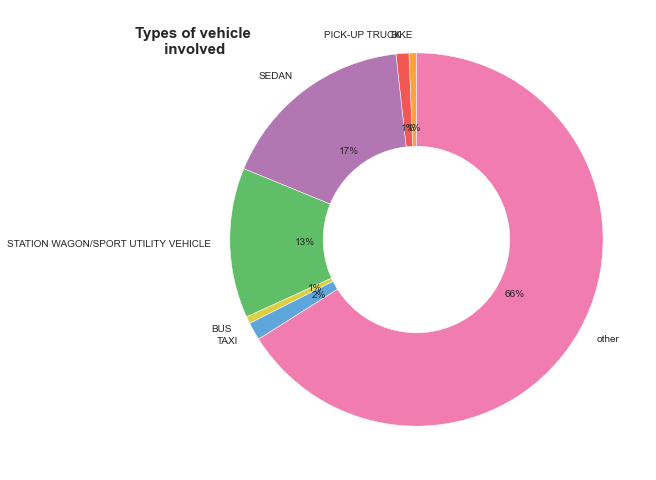

In [47]:
### Types of vehicles involved in the collisons ###

fig1, ax1 = plt.subplots(figsize = (8,8))

explode = np.zeros(len(vehicles))
ax1.pie(N_vehicles,labels=vehicles, autopct='%1.0f%%', explode = explode ,
        colors = ['#FAA43A','#F15854', '#B276B2','#60BD68', '#DECF3F', '#5DA5DA','#F17CB0'],
        startangle=90, textprops = {'fontsize': 10})

#draw circle
centre_circle = plt.Circle((0,0),0.50,fc='white')
fig = plt.gcf()
fig.gca().add_artist(centre_circle)

# Equal aspect ratio ensures that pie is drawn as a circle
#ax1.axis('equal')  
#plt.tight_layout()
plt.text(-1.2,1,'Types of vehicle\n involved',fontsize = 15, ha = 'center', weight = 'bold');
#plt.title('Type of vehicles involved',fontsize = 20, ha = 'center',weight = 'bold');
fig.savefig('vehicles.png', transparent=True, bbox_inches='tight')

In [48]:
# count number of motorist, cyclist and pedestrian injured and killed

mot_injured = data_df['number_of_motorist_injured'].sum()
cyc_injured = data_df['number_of_cyclist_injured'].sum()
ped_injured = data_df['number_of_pedestrians_injured'].sum()

mot_killed = data_df['number_of_motorist_killed'].sum()
cyc_killed = data_df['number_of_cyclist_killed'].sum()
ped_killed = data_df['number_of_pedestrians_killed'].sum()

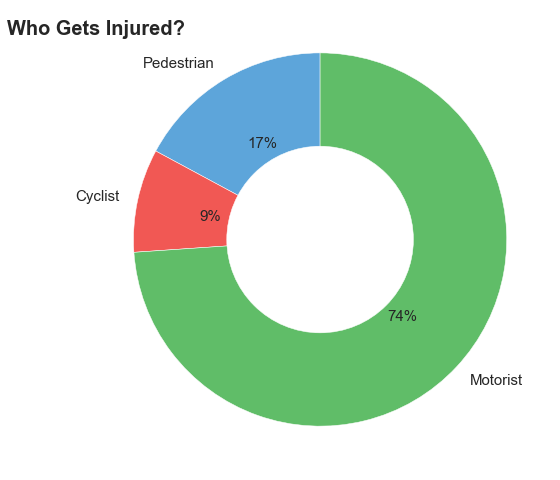

In [49]:
### Who gets injured? ###

fig1, ax1 = plt.subplots(figsize = (8,8))

who_injured = [ped_injured,cyc_injured,mot_injured]
labels = ['Pedestrian', 'Cyclist', 'Motorist']


ax1.pie(who_injured,labels=labels, autopct='%1.0f%%',
        colors = ['#5DA5DA','#F15854','#60BD68'],
        startangle=90, textprops = {'fontsize': 15})

#draw circle
centre_circle = plt.Circle((0,0),0.50,fc='white')
fig = plt.gcf()
fig.gca().add_artist(centre_circle)

# add text
plt.text(-1.2,1.1,'Who Gets Injured?',fontsize = 20, ha = 'center', weight = 'bold');

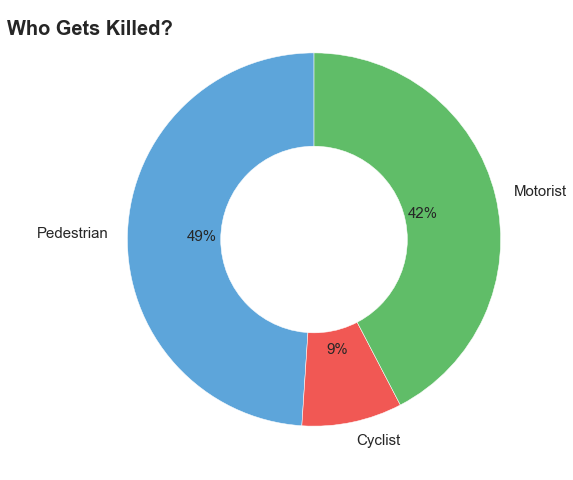

In [50]:
### Who gets killed? ###

fig1, ax1 = plt.subplots(figsize = (8,8))

who_killed = [ped_killed,cyc_killed,mot_killed]
labels = ['Pedestrian', 'Cyclist', 'Motorist']
ax1.pie(who_killed,labels=labels, autopct='%1.0f%%',
        colors = ['#5DA5DA','#F15854','#60BD68'],
        startangle=90, textprops = {'fontsize': 15})

#draw circle
centre_circle = plt.Circle((0,0),0.50,fc='white')
fig = plt.gcf()
fig.gca().add_artist(centre_circle)

# add text
plt.text(-1.2,1.1,'Who Gets Killed?',fontsize = 20, ha = 'center', weight = 'bold');
#plt.title('Type of vehicles involved',fontsize = 20, ha = 'center',weight = 'bold');

In [ ]:
### NYC map for reference by latitude/longitude and borough ###

BOROUGHs = np.unique(data_df['borough'])
colors = [plt.cm.tab10(i/float(len(BOROUGHs)-1)) for i in range(len(BOROUGHs))]

# Draw Plot for Each Category
plt.figure(figsize=(10, 10), dpi= 80, facecolor='w', edgecolor='k')

for i, BOROUGH in enumerate(BOROUGHs):
    plt.scatter('longitude', 'latitude', 
                data=data_df.loc[data_df.borough==BOROUGH, :], 
                s=20, cmap=colors[i], label=str(BOROUGH))

# Decorations
plt.gca().set(xlim=(-74.28, -73.65), ylim=(40.48, 40.93),
              xlabel='longitude', ylabel='latitude')

plt.xticks(fontsize=12); plt.yticks(fontsize=12)
plt.title("BOROUGH vs longitude/latitude", fontsize=22)
plt.legend(fontsize=8)    
plt.show()
